# Imports

In [5]:
import sys
sys.path.append('..')

In [6]:
# analysis
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.base import clone
from tqdm import tqdm
from statsmodels.stats.multitest import fdrcorrection
import h5py

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# local
import alignment.alignment_utils as utils
from alignment.AlignCCA import AlignCCA
from alignment.alignment_utils import cnd_avg
from decomposition.DimRedReshape import DimRedReshape

%matplotlib inline

In [7]:
def mean_stat(a, b, axis=0):
    return np.mean(a, axis=axis) - np.mean(b, axis=axis)

# Params

In [1]:
paper_pt_dict = {'S14': 'S1', 'S26': 'S2', 'S33': 'S3', 'S22': 'S4', 'S23': 'S5', 'S39': 'S6', 'S58': 'S7', 'S62': 'S8'}

In [2]:
DATA_PATH = '../data/results/decoding/'

In [3]:
phon_labels = ['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k']
artic_labels = ['low', 'high', 'labial', 'dorsal']
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [4]:
def cmat_acc(y_true, y_pred):
    cmat = confusion_matrix(y_true, y_pred)
    acc_cmat = np.trace(cmat) / np.sum(cmat)
    return acc_cmat

def cmat_wrap(y_true_iter, y_pred_iter):
    accs = []
    for y_true, y_pred in zip(y_true_iter, y_pred_iter):
        accs.append(cmat_acc(y_true, y_pred))
    return np.array(accs)

# Data Visualization

### Plotting utils

In [8]:
px_colors = [
             '#636EFA',
             '#EF553B',
             '#AB63FA',
             '#00CC96',
            #  '#72B7B2',
            #  '#990099',
            #  '#B6E880',

             
            #  '#FFA15A',
            #  '#19D3F3',
            #  '#FF6692',
            #  '#B6E880',
            #  '#FF97FF',
            #  '#FECB52',
            ]

In [9]:
# sns.set_theme(context='notebook', font='Arial', font_scale=1.15)
sns.set_theme(font='Arial', font_scale=1.2, style='white', palette=px_colors)
sns.set_style(rc={
    # 'axes.edgecolor': 'gray',
    'axes.linewidth': 0.5,
    'xtick.bottom': True,
    'ytick.left': True,
    })

In [10]:
from matplotlib.colors import LinearSegmentedColormap

parula_data = cm_data = [[0.2422, 0.1504, 0.6603],
[0.2444, 0.1534, 0.6728],
[0.2464, 0.1569, 0.6847],
[0.2484, 0.1607, 0.6961],
[0.2503, 0.1648, 0.7071],
[0.2522, 0.1689, 0.7179],
[0.254, 0.1732, 0.7286],
[0.2558, 0.1773, 0.7393],
[0.2576, 0.1814, 0.7501],
[0.2594, 0.1854, 0.761],
[0.2611, 0.1893, 0.7719],
[0.2628, 0.1932, 0.7828],
[0.2645, 0.1972, 0.7937],
[0.2661, 0.2011, 0.8043],
[0.2676, 0.2052, 0.8148],
[0.2691, 0.2094, 0.8249],
[0.2704, 0.2138, 0.8346],
[0.2717, 0.2184, 0.8439],
[0.2729, 0.2231, 0.8528],
[0.274, 0.228, 0.8612],
[0.2749, 0.233, 0.8692],
[0.2758, 0.2382, 0.8767],
[0.2766, 0.2435, 0.884],
[0.2774, 0.2489, 0.8908],
[0.2781, 0.2543, 0.8973],
[0.2788, 0.2598, 0.9035],
[0.2794, 0.2653, 0.9094],
[0.2798, 0.2708, 0.915],
[0.2802, 0.2764, 0.9204],
[0.2806, 0.2819, 0.9255],
[0.2809, 0.2875, 0.9305],
[0.2811, 0.293, 0.9352],
[0.2813, 0.2985, 0.9397],
[0.2814, 0.304, 0.9441],
[0.2814, 0.3095, 0.9483],
[0.2813, 0.315, 0.9524],
[0.2811, 0.3204, 0.9563],
[0.2809, 0.3259, 0.96],
[0.2807, 0.3313, 0.9636],
[0.2803, 0.3367, 0.967],
[0.2798, 0.3421, 0.9702],
[0.2791, 0.3475, 0.9733],
[0.2784, 0.3529, 0.9763],
[0.2776, 0.3583, 0.9791],
[0.2766, 0.3638, 0.9817],
[0.2754, 0.3693, 0.984],
[0.2741, 0.3748, 0.9862],
[0.2726, 0.3804, 0.9881],
[0.271, 0.386, 0.9898],
[0.2691, 0.3916, 0.9912],
[0.267, 0.3973, 0.9924],
[0.2647, 0.403, 0.9935],
[0.2621, 0.4088, 0.9946],
[0.2591, 0.4145, 0.9955],
[0.2556, 0.4203, 0.9965],
[0.2517, 0.4261, 0.9974],
[0.2473, 0.4319, 0.9983],
[0.2424, 0.4378, 0.9991],
[0.2369, 0.4437, 0.9996],
[0.2311, 0.4497, 0.9995],
[0.225, 0.4559, 0.9985],
[0.2189, 0.462, 0.9968],
[0.2128, 0.4682, 0.9948],
[0.2066, 0.4743, 0.9926],
[0.2006, 0.4803, 0.9906],
[0.195, 0.4861, 0.9887],
[0.1903, 0.4919, 0.9867],
[0.1869, 0.4975, 0.9844],
[0.1847, 0.503, 0.9819],
[0.1831, 0.5084, 0.9793],
[0.1818, 0.5138, 0.9766],
[0.1806, 0.5191, 0.9738],
[0.1795, 0.5244, 0.9709],
[0.1785, 0.5296, 0.9677],
[0.1778, 0.5349, 0.9641],
[0.1773, 0.5401, 0.9602],
[0.1768, 0.5452, 0.956],
[0.1764, 0.5504, 0.9516],
[0.1755, 0.5554, 0.9473],
[0.174, 0.5605, 0.9432],
[0.1716, 0.5655, 0.9393],
[0.1686, 0.5705, 0.9357],
[0.1649, 0.5755, 0.9323],
[0.161, 0.5805, 0.9289],
[0.1573, 0.5854, 0.9254],
[0.154, 0.5902, 0.9218],
[0.1513, 0.595, 0.9182],
[0.1492, 0.5997, 0.9147],
[0.1475, 0.6043, 0.9113],
[0.1461, 0.6089, 0.908],
[0.1446, 0.6135, 0.905],
[0.1429, 0.618, 0.9022],
[0.1408, 0.6226, 0.8998],
[0.1383, 0.6272, 0.8975],
[0.1354, 0.6317, 0.8953],
[0.1321, 0.6363, 0.8932],
[0.1288, 0.6408, 0.891],
[0.1253, 0.6453, 0.8887],
[0.1219, 0.6497, 0.8862],
[0.1185, 0.6541, 0.8834],
[0.1152, 0.6584, 0.8804],
[0.1119, 0.6627, 0.877],
[0.1085, 0.6669, 0.8734],
[0.1048, 0.671, 0.8695],
[0.1009, 0.675, 0.8653],
[0.0964, 0.6789, 0.8609],
[0.0914, 0.6828, 0.8562],
[0.0855, 0.6865, 0.8513],
[0.0789, 0.6902, 0.8462],
[0.0713, 0.6938, 0.8409],
[0.0628, 0.6972, 0.8355],
[0.0535, 0.7006, 0.8299],
[0.0433, 0.7039, 0.8242],
[0.0328, 0.7071, 0.8183],
[0.0234, 0.7103, 0.8124],
[0.0155, 0.7133, 0.8064],
[0.0091, 0.7163, 0.8003],
[0.0046, 0.7192, 0.7941],
[0.0019, 0.722, 0.7878],
[0.0009, 0.7248, 0.7815],
[0.0018, 0.7275, 0.7752],
[0.0046, 0.7301, 0.7688],
[0.0094, 0.7327, 0.7623],
[0.0162, 0.7352, 0.7558],
[0.0253, 0.7376, 0.7492],
[0.0369, 0.74, 0.7426],
[0.0504, 0.7423, 0.7359],
[0.0638, 0.7446, 0.7292],
[0.077, 0.7468, 0.7224],
[0.0899, 0.7489, 0.7156],
[0.1023, 0.751, 0.7088],
[0.1141, 0.7531, 0.7019],
[0.1252, 0.7552, 0.695],
[0.1354, 0.7572, 0.6881],
[0.1448, 0.7593, 0.6812],
[0.1532, 0.7614, 0.6741],
[0.1609, 0.7635, 0.6671],
[0.1678, 0.7656, 0.6599],
[0.1741, 0.7678, 0.6527],
[0.1799, 0.7699, 0.6454],
[0.1853, 0.7721, 0.6379],
[0.1905, 0.7743, 0.6303],
[0.1954, 0.7765, 0.6225],
[0.2003, 0.7787, 0.6146],
[0.2061, 0.7808, 0.6065],
[0.2118, 0.7828, 0.5983],
[0.2178, 0.7849, 0.5899],
[0.2244, 0.7869, 0.5813],
[0.2318, 0.7887, 0.5725],
[0.2401, 0.7905, 0.5636],
[0.2491, 0.7922, 0.5546],
[0.2589, 0.7937, 0.5454],
[0.2695, 0.7951, 0.536],
[0.2809, 0.7964, 0.5266],
[0.2929, 0.7975, 0.517],
[0.3052, 0.7985, 0.5074],
[0.3176, 0.7994, 0.4975],
[0.3301, 0.8002, 0.4876],
[0.3424, 0.8009, 0.4774],
[0.3548, 0.8016, 0.4669],
[0.3671, 0.8021, 0.4563],
[0.3795, 0.8026, 0.4454],
[0.3921, 0.8029, 0.4344],
[0.405, 0.8031, 0.4233],
[0.4184, 0.803, 0.4122],
[0.4322, 0.8028, 0.4013],
[0.4463, 0.8024, 0.3904],
[0.4608, 0.8018, 0.3797],
[0.4753, 0.8011, 0.3691],
[0.4899, 0.8002, 0.3586],
[0.5044, 0.7993, 0.348],
[0.5187, 0.7982, 0.3374],
[0.5329, 0.797, 0.3267],
[0.547, 0.7957, 0.3159],
[0.5609, 0.7943, 0.305],
[0.5748, 0.7929, 0.2941],
[0.5886, 0.7913, 0.2833],
[0.6024, 0.7896, 0.2726],
[0.6161, 0.7878, 0.2622],
[0.6297, 0.7859, 0.2521],
[0.6433, 0.7839, 0.2423],
[0.6567, 0.7818, 0.2329],
[0.6701, 0.7796, 0.2239],
[0.6833, 0.7773, 0.2155],
[0.6963, 0.775, 0.2075],
[0.7091, 0.7727, 0.1998],
[0.7218, 0.7703, 0.1924],
[0.7344, 0.7679, 0.1852],
[0.7468, 0.7654, 0.1782],
[0.759, 0.7629, 0.1717],
[0.771, 0.7604, 0.1658],
[0.7829, 0.7579, 0.1608],
[0.7945, 0.7554, 0.157],
[0.806, 0.7529, 0.1546],
[0.8172, 0.7505, 0.1535],
[0.8281, 0.7481, 0.1536],
[0.8389, 0.7457, 0.1546],
[0.8495, 0.7435, 0.1564],
[0.86, 0.7413, 0.1587],
[0.8703, 0.7392, 0.1615],
[0.8804, 0.7372, 0.165],
[0.8903, 0.7353, 0.1695],
[0.9, 0.7336, 0.1749],
[0.9093, 0.7321, 0.1815],
[0.9184, 0.7308, 0.189],
[0.9272, 0.7298, 0.1973],
[0.9357, 0.729, 0.2061],
[0.944, 0.7285, 0.2151],
[0.9523, 0.7284, 0.2237],
[0.9606, 0.7285, 0.2312],
[0.9689, 0.7292, 0.2373],
[0.977, 0.7304, 0.2418],
[0.9842, 0.733, 0.2446],
[0.99, 0.7365, 0.2429],
[0.9946, 0.7407, 0.2394],
[0.9966, 0.7458, 0.2351],
[0.9971, 0.7513, 0.2309],
[0.9972, 0.7569, 0.2267],
[0.9971, 0.7626, 0.2224],
[0.9969, 0.7683, 0.2181],
[0.9966, 0.774, 0.2138],
[0.9962, 0.7798, 0.2095],
[0.9957, 0.7856, 0.2053],
[0.9949, 0.7915, 0.2012],
[0.9938, 0.7974, 0.1974],
[0.9923, 0.8034, 0.1939],
[0.9906, 0.8095, 0.1906],
[0.9885, 0.8156, 0.1875],
[0.9861, 0.8218, 0.1846],
[0.9835, 0.828, 0.1817],
[0.9807, 0.8342, 0.1787],
[0.9778, 0.8404, 0.1757],
[0.9748, 0.8467, 0.1726],
[0.972, 0.8529, 0.1695],
[0.9694, 0.8591, 0.1665],
[0.9671, 0.8654, 0.1636],
[0.9651, 0.8716, 0.1608],
[0.9634, 0.8778, 0.1582],
[0.9619, 0.884, 0.1557],
[0.9608, 0.8902, 0.1532],
[0.9601, 0.8963, 0.1507],
[0.9596, 0.9023, 0.148],
[0.9595, 0.9084, 0.145],
[0.9597, 0.9143, 0.1418],
[0.9601, 0.9203, 0.1382],
[0.9608, 0.9262, 0.1344],
[0.9618, 0.932, 0.1304],
[0.9629, 0.9379, 0.1261],
[0.9642, 0.9437, 0.1216],
[0.9657, 0.9494, 0.1168],
[0.9674, 0.9552, 0.1116],
[0.9692, 0.9609, 0.1061],
[0.9711, 0.9667, 0.1001],
[0.973, 0.9724, 0.0938],
[0.9749, 0.9782, 0.0872],
[0.9769, 0.9839, 0.0805]]

parula_map = LinearSegmentedColormap.from_list('parula', parula_data)

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def chan_disp(data, chan_map, title, label, figsize=(8, 6), cbar_lower=None, cbar_upper=None, cmap=None):

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    if cmap is None:
        cmap = parula_map

    chan_data = np.array([data[int(i)] if not np.isnan(i) else np.nan for i in (chan_map.flatten()-1)])
    chan_data = chan_data.reshape(chan_map.shape)
    f = plt.figure(figsize=figsize)
    im = plt.imshow(chan_data, cmap=parula_map)
    im.set_clim(clim[0], clim[1])
    # plt.gca().invert_yaxis()
    # plt.contourf(chan_data, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    cbar.outline.set_visible(False)

    sns.despine(left=True, bottom=True)
    
    plt.show()

def chan_disp_seq(data, chan_map, t, t_ranges, labs, title, label, figsize=(3, 6), cbar_pos=[0.81, 0.56, 0.01, 0.3], sup_pos=0.95, cbar_lower=None, cbar_upper=None):
    f, tot_axs = plt.subplots(len(labs), len(t_ranges), figsize=(figsize[0]*len(t_ranges), figsize[1]*len(labs)))

    if len(labs) == 1:
        tot_axs = tot_axs[np.newaxis,:]

    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    std_mult = 3
    # clim = [max(0, mean_val - std_mult*std_val), mean_val + std_mult*std_val]
    if cbar_lower is None:
        cbar_lower = mean_val - std_mult*std_val
    if cbar_upper is None:
        cbar_upper = mean_val + std_mult*std_val
    clim = [cbar_lower, cbar_upper]

    for j, lab in enumerate(labs):
        lab_data = data[j]
        axs = tot_axs[j]
        for i, t_range in enumerate(t_ranges):
            t_inds = np.where((t >= t_range[0]) & (t < t_range[1]))[0]
            chan_data = np.array([lab_data[t_inds,:].mean(axis=0)[int(k)] if not np.isnan(k) else np.nan for k in (chan_map.flatten()-1)])
            chan_data = chan_data.reshape(chan_map.shape)
            im = axs[i].imshow(chan_data, cmap=parula_map)
            im.set_clim(clim[0], clim[1])
            if i==0:
                axs[i].set_ylabel(lab)
            if j==0:
                axs[i].set_title(f'{t_range[0]} -> {t_range[1]}s')
            axs[i].set_xticks([])
            axs[i].set_yticks([])
            

        # divider = make_axes_locatable(plt.gca())
        # cax = divider.append_axes('right', size='5%', pad=0.05)

        # cbar = plt.colorbar(im, cax=cax)
        
        # cbar.set_label(label)
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes(cbar_pos)
    cbar = f.colorbar(im, cax=cbar_ax)
    cbar.set_label(label)

    # f.tight_layout(rect=[0, 0.03, 1, 0.95])
    f.suptitle(title, y=sup_pos)
    plt.show()

In [12]:
def rgb2hex(r,g,b):
    return "#{:02x}{:02x}{:02x}".format(r,g,b)

In [13]:
def get_ci_data(ax):
    paths = [child for child in ax.get_children() if isinstance(child, mpl.collections.PolyCollection)]
    ci_data = []
    for path in paths:
        vertices = path.get_paths()[0].vertices  # Array of shape (n, 2)

        # ci y coords - contains lower bounds then upper bounds in 1D array
        ci_vals_tot = vertices[:-1, 1]

        ci_vals = np.zeros((200, 2))
        ci_vals[:,0] = ci_vals_tot[1:201]
        ci_vals[:,1] = ci_vals_tot[201:-1]
        ci_vals[:,1] = ci_vals[:,1][::-1] # reverse the order of the second half
        ci_data.append(ci_vals)
        
    return ci_data

### Panel a

In [30]:
pt_list = ['S14', 'S26', 'S33', 'S23', 'S22', 'S39', 'S58', 'S62']
pInd_list = [-1]

wide_dfs = []
long_dfs = []
for pt in pt_list:
    for p_ind in pInd_list:
        p_str = 'pAll' if p_ind == -1 else f'p{p_ind}'
        
        p_tar = np.zeros((3, 50))
        p_tar[0,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'ptSpecific/{pt}/{pt}_{p_str}_ptSpecific_rbf_noCV.pkl')[k] for k in ['y_true', 'y_pred']])
        p_tar[1,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'pooled/S62_added/{pt}/unaligned/{pt}_{p_str}_pooled_unaligned_rbf_noCV.pkl')[k] for k in ['y_true', 'y_pred']])
        p_tar[2,:] = cmat_wrap(*[utils.load_pkl(DATA_PATH + f'pooled/S62_added/{pt}/cca/{pt}_{p_str}_pooled_ccaAlignedNew_rbf_noCV.pkl')[k] for k in ['y_true', 'y_pred']])
        decode_df = pd.DataFrame(p_tar.T, columns=['Patient-specific', 'Unaligned cross-patient', 'Aligned cross-patient'])


        wide_dfs.append(decode_df)
        decode_df = pd.melt(decode_df, var_name='Decoding Context', value_name='accuracy')
        decode_df['Patient'] = paper_pt_dict[pt]
        decode_df['Phoneme Index'] = p_str
        cols = decode_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        decode_df = decode_df[cols]
        long_dfs.append(decode_df)
        
decode_df_wide = pd.concat(wide_dfs)
decode_df_long = pd.concat(long_dfs)

In [31]:
decode_df_long

,Phoneme Index,Decoding Context,accuracy,Patient
0,pAll,Patient-specific,0.398148,S1
1,pAll,Patient-specific,0.388889,S1
2,pAll,Patient-specific,0.379630,S1
3,pAll,Patient-specific,0.365741,S1
4,pAll,Patient-specific,0.370370,S1
...,...,...,...,...
145,pAll,Aligned cross-patient,0.314607,S8
146,pAll,Aligned cross-patient,0.346442,S8
147,pAll,Aligned cross-patient,0.335206,S8
148,pAll,Aligned cross-patient,0.346442,S8


In [63]:
fig_ind = 'pAll'
fig_df = decode_df_long[decode_df_long['Phoneme Index'] == fig_ind]
fig = px.box(fig_df, x='Patient', y="accuracy", color='Decoding Context', points='all', width=1000, height=600, color_discrete_sequence=['#636EFA', '#EF553B', '#AB63FA'])
# fig = px.box(decode_df, x='Patient', y="accuracy", color='Decoding Context', points='all', width=1200, height=2400, color_discrete_sequence=px_colors, facet_row='Phoneme Index')
# fig = px.box(decode_df, x='subject', y="accuracy", color='Decoding Context', points='all', width=850, height=500, color_discrete_sequence=px_colors[1:])
fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
# fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=0.02,
        xanchor='left',
        x=0.01,
        title_text=''
    ),
    # showlegend=False,
    # title_text=f'Phoneme Decoding - Target Patient in Training Set',
    title_text=f'Decoder Trained on Target Patient',
    # title_text='All Phonemes - Pooled Decoding',
    # title_text=f'Aligned Decoding Accuracy With Varied Amounts of Pooled Patients',
    # title_text='Decoder Only Trained on Non-Target Patients',
    title_x=0.5,
    font=dict(size=20, family='Arial')
)
fig.update_xaxes(
    title='Target Patient',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1,2,3],
    # ticktext=['S1', 'S2', 'S3', 'S4'],
    # range=[-0.5, 4.5],
    tickvals=[0,1,2],
    # ticktext=['S1', 'S2', 'S4'],
    range=[-0.5, 2.5]
)
fig.update_yaxes(
    title='Decoding Accuracy',
    # title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.6]
)
fig.show()

In [34]:
pt_spf

Series([], Name: accuracy, dtype: float64)

In [36]:
from scipy.stats import f_oneway, tukey_hsd, false_discovery_control

pts = paper_pt_dict.values()
p_arr = np.zeros((len(pts), 3))
for i, pt in enumerate(pts):
    pt_spf = decode_df_long[(decode_df_long['Patient'] == pt) & (decode_df_long['Decoding Context'] == 'Patient-specific')]['accuracy']
    pt_una = decode_df_long[(decode_df_long['Patient'] == pt) & (decode_df_long['Decoding Context'] == 'Unaligned cross-patient')]['accuracy']
    pt_cca = decode_df_long[(decode_df_long['Patient'] == pt) & (decode_df_long['Decoding Context'] == 'Aligned cross-patient')]['accuracy']

    stat, anova_p = f_oneway(pt_spf, pt_una, pt_cca)
    res = tukey_hsd(pt_spf, pt_una, pt_cca)
    cca_ps_p = res.pvalue[0,2]
    cca_una_p = res.pvalue[1,2]

    p_arr[i, :] = [anova_p, cca_ps_p, cca_una_p]

    print(f'{pt} (Uncorrected): ANOVA p = {anova_p}, CCA vs. PS p = {cca_ps_p}, CCA vs. Unaligned p = {cca_una_p}')

# Correct for multiple comparisons
corrected_pvals = false_discovery_control(p_arr.flatten()).reshape(p_arr.shape)
print()

for i, pt in enumerate(pts):
    print(f'{pt} (Corrected): ANOVA p = {corrected_pvals[i,0]}, CCA vs. PS p = {corrected_pvals[i,1]}, CCA vs. Unaligned p = {corrected_pvals[i,2]}')

S1 (Uncorrected): ANOVA p = 1.888200647303227e-82, CCA vs. PS p = 2.398081733190338e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
S2 (Uncorrected): ANOVA p = 1.0799199629556557e-124, CCA vs. PS p = 2.1538326677728037e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
S3 (Uncorrected): ANOVA p = 5.668700009389686e-109, CCA vs. PS p = 2.1538326677728037e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
S4 (Uncorrected): ANOVA p = 1.0234689651451931e-53, CCA vs. PS p = 2.1538326677728037e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
S5 (Uncorrected): ANOVA p = 1.5621522803193772e-54, CCA vs. PS p = 2.1538326677728037e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
S6 (Uncorrected): ANOVA p = 1.702250171965963e-44, CCA vs. PS p = 2.1538326677728037e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
S7 (Uncorrected): ANOVA p = 7.995638070158545e-73, CCA vs. PS p = 2.1538326677728037e-14, CCA vs. Unaligned p = 2.1538326677728037e-14
S8 (Uncorrected): ANOVA p = 4.187250007435089e-85, 

In [64]:
fig_ind = 'pAll'
# fig_df = decode_df_long[decode_df_long['Phoneme Index'] == fig_ind]
fig_df = decode_df_long[decode_df_long['Phoneme Index'] == fig_ind].drop(columns=['Phoneme Index']).groupby(['Patient', 'Decoding Context'], sort=False).mean().reset_index()
# fig_df = mean_df

fig = px.line(fig_df, x='Decoding Context', y="accuracy", color='Patient', width=1000, height=600, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.add_traces(px.box(fig_df, x='Decoding Context', y="accuracy").data)
# fig = px.box(fig_df, y="accuracy", x='Decoding Context', width=900, height=600)
# fig = px.box(decode_df, x='Patient', y="accuracy", color='Decoding Context', points='all', width=1200, height=2400, color_discrete_sequence=px_colors, facet_row='Phoneme Index')
# fig = px.box(decode_df, x='subject', y="accuracy", color='Decoding Context', points='all', width=850, height=500, color_discrete_sequence=px_colors[1:])
fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
# fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=0.02,
        xanchor='left',
        x=0.01,
        title_text=''
    ),
    # showlegend=False,
    # title_text=f'Phoneme Decoding - Target Patient in Training Set',
    title_text=f'Decoder Trained on Target Patient',
    # title_text='All Phonemes - Pooled Decoding',
    # title_text=f'Aligned Decoding Accuracy With Varied Amounts of Pooled Patients',
    # title_text='Decoder Only Trained on Non-Target Patients',
    title_x=0.5,
    font=dict(size=20, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1,2,3],
    # ticktext=['S1', 'S2', 'S3', 'S4'],
    # range=[-0.5, 4.5],
    # tickvals=[0,1,2],
    # ticktext=['S1', 'S2', 'S4'],
    # range=[-0.5, 2.5]
    # categoryorder='array',
    # categoryarray=['Patient-specific', 'Unaligned cross-patient', 'Aligned cross-patient']
)
fig.update_yaxes(
    title='Phoneme decoding Accuracy',
    # title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[0, 0.6]
)
fig.show()

### Panel b

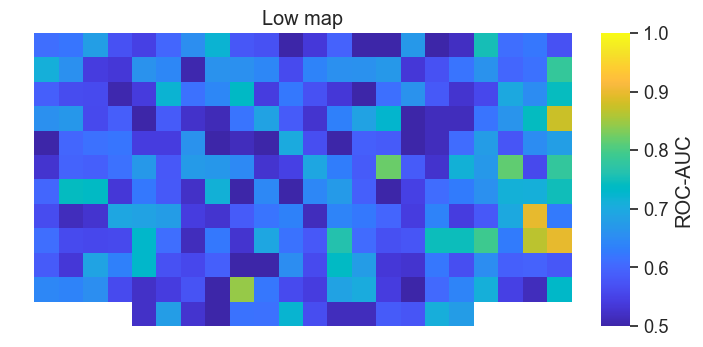

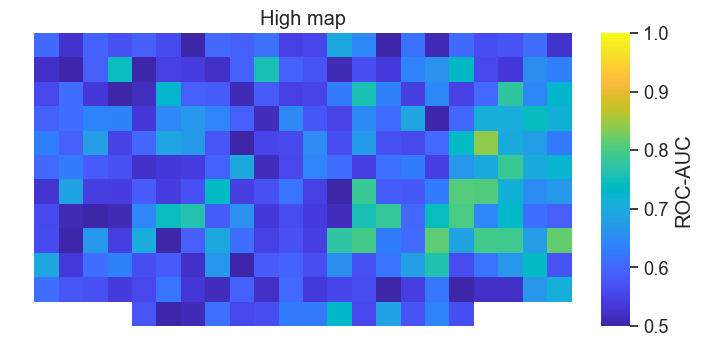

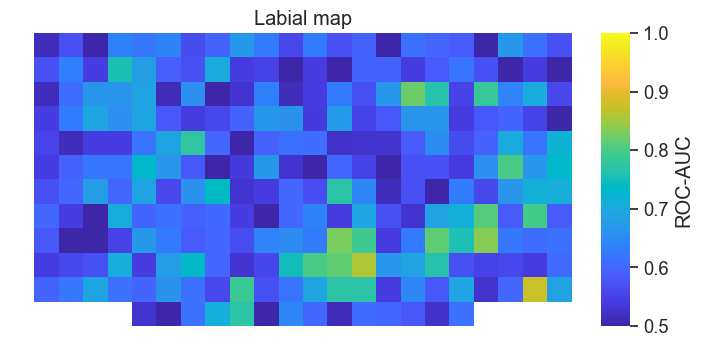

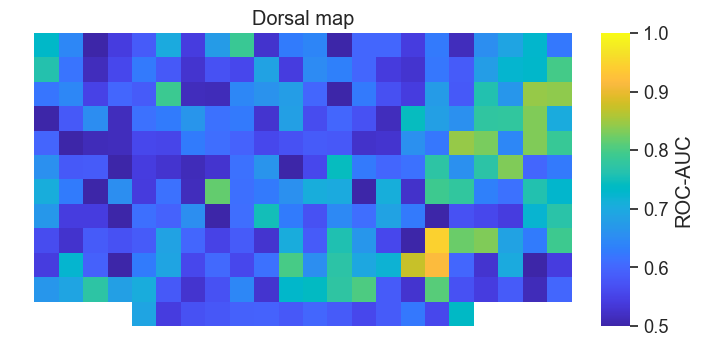

In [107]:
pt = 'S33'
for i, artic in enumerate(artic_labels):
    chan_disp(pt_artic_maps[pt]['weights'][i], pt_artic_maps[pt]['weight_map'], str.capitalize(f'{artic} map'), 'ROC-AUC', figsize=(8, 6), cbar_lower=0.5, cbar_upper=1)

In [21]:
all_pt_elec_data = [np.transpose(all_pt_dict[pt]['X1_map'].reshape(all_pt_dict[pt]['X1_map'].shape[0], -1, all_pt_dict[pt]['X1_map'].shape[-1]), axes=(0,2,1)) for pt in pt_names]
all_pt_good_chans = []
for i, (pt, d) in enumerate(zip(pt_names, all_pt_elec_data)):
    d[d == 0] = np.nan
    all_pt_good_chans.append(np.where(~np.isnan(d)[0,0,:])[0])
    all_pt_elec_data[i] = d[np.where(~np.isnan(d))].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1)

Dictionary to hold data for all patients being aligned to a given patient (target patients for alignment are the keys to `alignDict_allPts` )

In [22]:
alignDict_allPts = {}
for recon_pt in tqdm(pt_names, desc='Patients'):
    recon_ind = pt_names.index(recon_pt)

    aligners = {}
    for i, pt in enumerate(pt_names):
        if i == recon_ind:
            continue
        aligners[pt] = AlignCCA()
                    
    pcas = {}
    to_align = {}
    for pt in pt_names:
        pcas[pt] = PCA(n_components=30)
        to_align[pt] = pcas[pt].fit_transform(all_pt_elec_data[pt_names.index(pt)].reshape(-1, all_pt_elec_data[pt_names.index(pt)].shape[-1]))
        to_align[pt] = to_align[pt].reshape(all_pt_elec_data[pt_names.index(pt)].shape[0], all_pt_elec_data[pt_names.index(pt)].shape[1], -1)

    aligned_data = {}
    aligned_data_null = {}
    aligned_data[recon_pt] = to_align[recon_pt]
    aligned_data_null[recon_pt] = to_align[recon_pt]
    for i, pt in enumerate(pt_names):
        if i == recon_ind:
            continue

        to_align_seqs = [all_pt_phon_seqs[recon_pt], all_pt_phon_seqs[pt]]
        aligners[pt].fit(to_align[recon_pt], to_align[pt], to_align_seqs[0], to_align_seqs[1])
        aligned_data[pt] = aligners[pt].transform(to_align[pt])

        aligned_data_null[pt] = to_align[pt]
        
    alignDict_allPts[recon_pt] = {
        'pcas': pcas,
        'aligners': aligners,
        'dr_data': to_align,
        'aligned_data': aligned_data,
        'aligned_data_null': aligned_data_null,
    }

Patients: 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


##### S14 #####


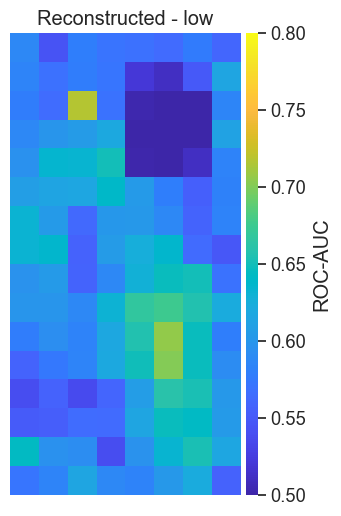

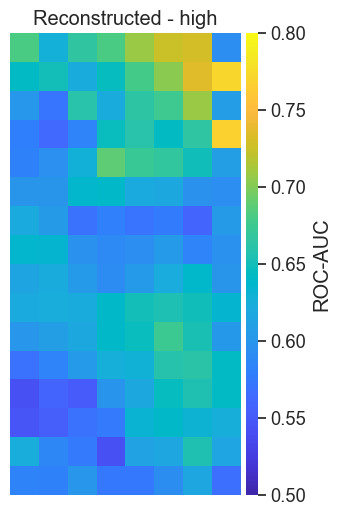

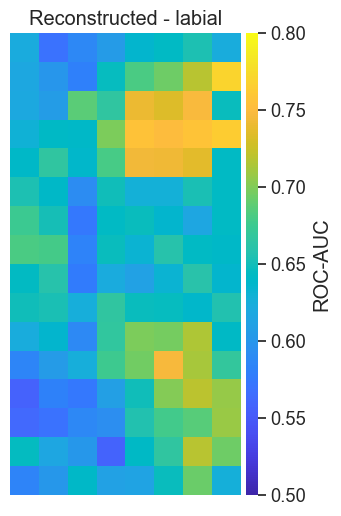

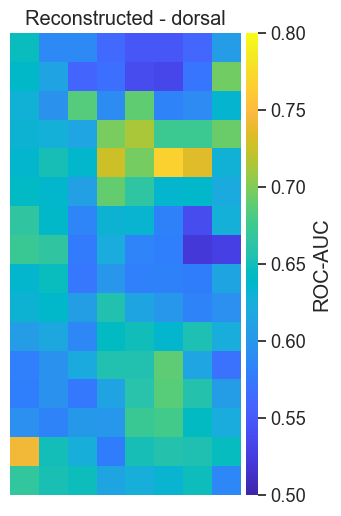

In [108]:
artic_map_sims = {}
artic_map_sims_null = {}
# for target_pt in pt_names:
for target_pt in ['S14']:
    print(f'##### {target_pt} #####')

    target_maps = pt_artic_maps[target_pt]['weights']
    target_pt_ind = pt_names.index(target_pt)
    target_dr = alignDict_allPts[target_pt]['pcas'][target_pt]
    target_chan_map = pt_artic_maps[target_pt]['weight_map']
    artic_map_sims[target_pt] = {}
    artic_map_sims_null[target_pt] = {}

    pt_names_artic_recon = [target_pt] + ['S33']

    for i_artic, lab in enumerate(artic_labels):
        map_target = target_maps[i_artic]

        for i_pt, input_pt in enumerate(pt_names_artic_recon[1:]):           
            map_input = pt_artic_maps[input_pt]['weights'][i_artic]
            input_pt_ind = pt_names.index(input_pt)

            input_dr = alignDict_allPts[target_pt]['pcas'][input_pt]
            align = alignDict_allPts[target_pt]['aligners'][input_pt]

            map_flat = map_input.flatten()[~np.isnan(map_input.flatten())]
            map_flat = map_flat[None, :] # expand dims for compatibility with transformations below

            # scale the mean of the pca to the articulator map space
            sc_input = MinMaxScaler(feature_range=(np.nanmin(map_flat), np.nanmax(map_flat)))
            sc_input.fit(all_pt_elec_data[input_pt_ind].reshape(-1, all_pt_elec_data[input_pt_ind].shape[-1]))
            sc_mean_input = np.squeeze(sc_input.transform(input_dr.mean_[None,:]))

            map_target_flat = map_target.flatten()[~np.isnan(map_target.flatten())]
            sc_target = MinMaxScaler(feature_range=(np.nanmin(map_target.flatten()), np.nanmax(map_target.flatten())))
            sc_target.fit(all_pt_elec_data[target_pt_ind].reshape(-1, all_pt_elec_data[target_pt_ind].shape[-1]))
            sc_mean_target = np.squeeze(sc_target.transform(target_dr.mean_[None,:]))

            map_dr = (map_flat - sc_mean_input) @ input_dr.components_.T
            M_a = align.M_a
            M_b = align.M_b
            map_align = map_dr @ M_b @ np.linalg.pinv(M_a)

            map_recon = map_align @ target_dr.components_

            chan_disp(map_recon.squeeze() + sc_mean_target, target_chan_map,
                      f'Reconstructed - {lab}', 'ROC-AUC', figsize=(8, 6),
                      cbar_lower=0.5, cbar_upper=0.8)


### Panel c

In [23]:
def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [110]:
artic_map_sims = {}
artic_map_sims_null = {}
for target_pt in ['S14']:
    print(f'##### {target_pt} #####')

    target_maps = pt_artic_maps[target_pt]['weights']
    target_pt_ind = pt_names.index(target_pt)
    target_dr = alignDict_allPts[target_pt]['pcas'][target_pt]
    target_chan_map = pt_artic_maps[target_pt]['weight_map']
    artic_map_sims[target_pt] = {}
    artic_map_sims_null[target_pt] = {}

    pt_names_artic_recon = [target_pt] + [pt for pt in pt_names if pt != target_pt]

    sim_values = []
    sim_values_null = []
    artic_recons = np.zeros((target_maps.shape[0], len(pt_names_artic_recon[1:]), all_pt_elec_data[pt_names.index(target_pt)].shape[-1]))
    artic_nulls = np.zeros((target_maps.shape[0], len(pt_names_artic_recon[1:]), all_pt_elec_data[pt_names.index(target_pt)].shape[-1]))
    for i_artic, lab in enumerate(artic_labels):
        map_target = target_maps[i_artic]

        for i_pt, input_pt in enumerate(pt_names_artic_recon[1:]):           
            map_input = pt_artic_maps[input_pt]['weights'][i_artic]
            input_pt_ind = pt_names.index(input_pt)

            input_dr = alignDict_allPts[target_pt]['pcas'][input_pt]
            align = alignDict_allPts[target_pt]['aligners'][input_pt]

            map_flat = map_input.flatten()[~np.isnan(map_input.flatten())]
            map_flat = map_flat[None, :] # expand dims for compatibility with transformations below

            # scale the mean of the pca to the articulator map space
            sc_input = MinMaxScaler(feature_range=(np.nanmin(map_flat), np.nanmax(map_flat)))
            sc_input.fit(all_pt_elec_data[input_pt_ind].reshape(-1, all_pt_elec_data[input_pt_ind].shape[-1]))
            sc_mean_input = np.squeeze(sc_input.transform(input_dr.mean_[None,:]))

            map_target_flat = map_target.flatten()[~np.isnan(map_target.flatten())]
            sc_target = MinMaxScaler(feature_range=(np.nanmin(map_target.flatten()), np.nanmax(map_target.flatten())))
            sc_target.fit(all_pt_elec_data[target_pt_ind].reshape(-1, all_pt_elec_data[target_pt_ind].shape[-1]))
            sc_mean_target = np.squeeze(sc_target.transform(target_dr.mean_[None,:]))

            map_dr = (map_flat - sc_mean_input) @ input_dr.components_.T

            M_a = align.M_a
            M_b = align.M_b
            map_align = map_dr @ M_b @ np.linalg.pinv(M_a)

            map_recon = map_align @ target_dr.components_
            map_null = map_dr @ target_dr.components_

            artic_recons[i_artic, i_pt, :] = map_recon.squeeze()
            artic_nulls[i_artic, i_pt, :] = map_null.squeeze()

        avg_recon_map = np.mean(artic_recons[i_artic], axis=0)
        avg_null_map = np.mean(artic_nulls[i_artic], axis=0)

        sim = cos_sim(avg_recon_map, map_target_flat - sc_mean_target)
        sim_values.append(sim)
        print(f'Cosine similarity between {lab} map reconstruction: {sim}')

        sim_null = cos_sim(avg_null_map, map_target_flat - sc_mean_target)
        sim_values_null.append(sim_null)
        print(f'Cosine similarity between {lab} map null reconstruction: {sim_null}')

        artic_map_sims[target_pt][lab] = sim
        artic_map_sims_null[target_pt][lab] = sim_null

##### S14 #####
Cosine similarity between low map reconstruction: 0.6706321568220244
Cosine similarity between low map null reconstruction: -0.04271136145621701
Cosine similarity between high map reconstruction: 0.3465821982611812
Cosine similarity between high map null reconstruction: 0.16614065382364432
Cosine similarity between labial map reconstruction: 0.7095805509574565
Cosine similarity between labial map null reconstruction: -0.08587312031416132
Cosine similarity between dorsal map reconstruction: 0.5258065466194144
Cosine similarity between dorsal map null reconstruction: -0.065400584087818


In [111]:
artic_sim_S1_df = pd.DataFrame(artic_map_sims).T
artic_sim_S1_df['Patient'] = artic_sim_S1_df.index
artic_sim_S1_df = artic_sim_S1_df.reset_index(drop=True)
artic_sim_S1_df = pd.melt(artic_sim_S1_df, id_vars=['Patient'], var_name='Articulator', value_name='Cosine Similarity')

artic_sim_null_S1_df = pd.DataFrame(artic_map_sims_null).T
artic_sim_null_S1_df['Patient'] = artic_sim_null_S1_df.index
artic_sim_null_S1_df = artic_sim_null_S1_df.reset_index(drop=True)
artic_sim_null_S1_df = pd.melt(artic_sim_null_S1_df, id_vars=['Patient'], var_name='Articulator', value_name='Cosine Similarity')

artic_sim_S1_df['Type'] = 'Aligned'
artic_sim_null_S1_df['Type'] = 'Unaligned'
artic_sim_full_S1_df = pd.concat([artic_sim_S1_df, artic_sim_null_S1_df])
artic_sim_full_S1_df['Articulator'] = artic_sim_full_S1_df['Articulator'].str.capitalize()
artic_sim_full_S1_df = artic_sim_full_S1_df[['Patient', 'Articulator', 'Type', 'Cosine Similarity']]
artic_sim_full_S1_df

,Patient,Articulator,Type,Cosine Similarity
0,S14,Dorsal,Aligned,0.525807
1,S14,High,Aligned,0.346582
2,S14,Labial,Aligned,0.709581
3,S14,Low,Aligned,0.670632
0,S14,Dorsal,Unaligned,-0.065401
1,S14,High,Unaligned,0.166141
2,S14,Labial,Unaligned,-0.085873
3,S14,Low,Unaligned,-0.042711


In [80]:
fig = px.histogram(artic_sim_full_S1_df, x='Articulator', y="Cosine Similarity", color='Type', barmode='group', width=800, height=600, color_discrete_sequence=[px_colors[0], '#7F7F7F'])

fig.add_hline(y=0, line_dash='dash', line_color='grey')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text='Similarity of S1 reconstructed articulator maps',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='Articulator Type',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
)
fig.update_yaxes(
    title='Cosine Similarity',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.2, 0.85],
)

# fig.write_image(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_3\S1_artic_recon.svg")
fig.show()

In [113]:
artic_map_sims = {}
artic_map_sims_null = {}
for target_pt in pt_names:
    print(f'##### {paper_pt_dict[target_pt]} #####')

    target_maps = pt_artic_maps[target_pt]['weights']
    target_pt_ind = pt_names.index(target_pt)
    target_dr = alignDict_allPts[target_pt]['pcas'][target_pt]
    target_chan_map = pt_artic_maps[target_pt]['weight_map']
    artic_map_sims[target_pt] = {}
    artic_map_sims_null[target_pt] = {}

    pt_names_artic_recon = [target_pt] + [pt for pt in pt_names if pt != target_pt]

    sim_values = []
    sim_values_null = []
    artic_recons = np.zeros((target_maps.shape[0], len(pt_names_artic_recon[1:]), all_pt_elec_data[pt_names.index(target_pt)].shape[-1]))
    artic_nulls = np.zeros((target_maps.shape[0], len(pt_names_artic_recon[1:]), all_pt_elec_data[pt_names.index(target_pt)].shape[-1]))
    for i_artic, lab in enumerate(artic_labels):
        map_target = target_maps[i_artic]

        for i_pt, input_pt in enumerate(pt_names_artic_recon[1:]):           
            map_input = pt_artic_maps[input_pt]['weights'][i_artic]
            input_pt_ind = pt_names.index(input_pt)

            input_dr = alignDict_allPts[target_pt]['pcas'][input_pt]
            align = alignDict_allPts[target_pt]['aligners'][input_pt]

            map_flat = map_input.flatten()[~np.isnan(map_input.flatten())]
            map_flat = map_flat[None, :] # expand dims for compatibility with transformations below

            # scale the mean of the pca to the articulator map space
            sc_input = MinMaxScaler(feature_range=(np.nanmin(map_flat), np.nanmax(map_flat)))
            sc_input.fit(all_pt_elec_data[input_pt_ind].reshape(-1, all_pt_elec_data[input_pt_ind].shape[-1]))
            sc_mean_input = np.squeeze(sc_input.transform(input_dr.mean_[None,:]))

            map_target_flat = map_target.flatten()[~np.isnan(map_target.flatten())]
            sc_target = MinMaxScaler(feature_range=(np.nanmin(map_target.flatten()), np.nanmax(map_target.flatten())))
            sc_target.fit(all_pt_elec_data[target_pt_ind].reshape(-1, all_pt_elec_data[target_pt_ind].shape[-1]))
            sc_mean_target = np.squeeze(sc_target.transform(target_dr.mean_[None,:]))

            map_dr = (map_flat - sc_mean_input) @ input_dr.components_.T

            M_a = align.M_a
            M_b = align.M_b
            map_align = map_dr @ M_b @ np.linalg.pinv(M_a)

            map_recon = map_align @ target_dr.components_
            map_null = map_dr @ target_dr.components_

            artic_recons[i_artic, i_pt, :] = map_recon.squeeze()
            artic_nulls[i_artic, i_pt, :] = map_null.squeeze()

        avg_recon_map = np.mean(artic_recons[i_artic], axis=0)
        avg_null_map = np.mean(artic_nulls[i_artic], axis=0)

        sim = cos_sim(avg_recon_map, map_target_flat - sc_mean_target)
        sim_values.append(sim)
        print(f'Cosine similarity between {lab} map reconstruction: {sim}')

        sim_null = cos_sim(avg_null_map, map_target_flat - sc_mean_target)
        sim_values_null.append(sim_null)
        print(f'Cosine similarity between {lab} map null reconstruction: {sim_null}')

        artic_map_sims[target_pt][lab] = sim
        artic_map_sims_null[target_pt][lab] = sim_null

##### S1 #####
Cosine similarity between low map reconstruction: 0.6706321568220244
Cosine similarity between low map null reconstruction: -0.04271136145621701
Cosine similarity between high map reconstruction: 0.3465821982611812
Cosine similarity between high map null reconstruction: 0.16614065382364432
Cosine similarity between labial map reconstruction: 0.7095805509574565
Cosine similarity between labial map null reconstruction: -0.08587312031416132
Cosine similarity between dorsal map reconstruction: 0.5258065466194144
Cosine similarity between dorsal map null reconstruction: -0.065400584087818
##### S2 #####
Cosine similarity between low map reconstruction: 0.0495059759573917
Cosine similarity between low map null reconstruction: -0.02540922760920568
Cosine similarity between high map reconstruction: 0.20092183110367018
Cosine similarity between high map null reconstruction: -0.06103622373930063
Cosine similarity between labial map reconstruction: -0.17253134246553464
Cosine simil

In [114]:
artic_sim_df = pd.DataFrame(artic_map_sims).T
artic_sim_df['Patient'] = [paper_pt_dict[p] for p in artic_sim_df.index]
artic_sim_df = artic_sim_df.reset_index(drop=True)
artic_sim_df = pd.melt(artic_sim_df, id_vars=['Patient'], var_name='Articulator', value_name='Cosine Similarity')

artic_sim_null_df = pd.DataFrame(artic_map_sims_null).T
artic_sim_null_df['Patient'] = [paper_pt_dict[p] for p in artic_sim_null_df.index]
artic_sim_null_df = artic_sim_null_df.reset_index(drop=True)
artic_sim_null_df = pd.melt(artic_sim_null_df, id_vars=['Patient'], var_name='Articulator', value_name='Cosine Similarity')

artic_sim_df['Type'] = 'Aligned'
artic_sim_null_df['Type'] = 'Unaligned'
artic_sim_full_df = pd.concat([artic_sim_df, artic_sim_null_df])
artic_sim_full_df['Articulator'] = artic_sim_full_df['Articulator'].str.capitalize()
artic_sim_full_df = artic_sim_full_df[['Patient', 'Articulator', 'Type', 'Cosine Similarity']]
artic_sim_full_df

,Patient,Articulator,Type,Cosine Similarity
0,S1,Low,Aligned,0.670632
1,S2,Low,Aligned,0.049506
2,S5,Low,Aligned,0.590881
3,S3,Low,Aligned,0.177949
4,S4,Low,Aligned,0.325656
...,...,...,...,...
27,S3,Dorsal,Unaligned,0.024888
28,S4,Dorsal,Unaligned,0.031496
29,S6,Dorsal,Unaligned,0.040749
30,S7,Dorsal,Unaligned,-0.160110


In [84]:
fig = px.box(artic_sim_full_df, color='Type', x='Type', y="Cosine Similarity", points='all', width=800, height=600, color_discrete_sequence=[px.colors.qualitative.Plotly[0], '#7F7F7F'])
# fig = px.histogram(artic_sim_full_df, x='Articulator', y="Cosine Similarity", color='Type', barmode='group', width=800, height=600, color_discrete_sequence=px.colors.qualitative.Plotly)
# fig = px.box(artic_sim_full_df, x='Type', y="Cosine Similarity", width=800, height=600, color_discrete_sequence=px.colors.qualitative.Plotly)

# fig.update_traces(mode='lines')
# fig.add_traces(px.box(recon_acc_df, x='Condition', y="Decoding Accuracy").data)
# fig = px.box(corr_df, x='Condition', y="Correlation", width=800, height=500)
# fig.add_traces(px.line(corr_df, x='Condition', y="Correlation", color='Patient', error_y='Error').data)
# fig.update_traces(mode='markers+lines')
fig.add_hline(y=0, line_dash='dash', line_color='grey')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text='Similarity of reconstructed articulator maps for all patients',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    tickvals=[],
    range=[-0.6, 1.5],
)
fig.update_yaxes(
    title='Cosine Similarity',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.4, 0.9],
)

# fig.write_image(r"C:\Users\zms14\Box\CoganLab\IndividualMeetings\Zac\manuscripts\cross_patient_speech_decoding\figures\fig_3\allPt_artic_recon.svg")
fig.show()

In [130]:
recon = artic_sim_full_df[artic_sim_full_df['Type'] == 'Aligned']['Cosine Similarity']
recon_null = artic_sim_full_df[artic_sim_full_df['Type'] == 'Unaligned']['Cosine Similarity']
artic_sim_res = stats.permutation_test((recon, recon_null), mean_stat, n_resamples=10000, vectorized=True, permutation_type='samples')
# artic_sim_res = stats.wilcoxon(recon, recon_null)
print('Articulator Map Aligned vs Unaligned p-value:')
print(artic_sim_res.pvalue)

Articulator Map Aligned vs Unaligned p-value:
0.00019998000199980003


### Panel d

In [85]:
reconDict_allPts = {}
for recon_pt in pt_names:
    pcas = alignDict_allPts[recon_pt]['pcas']
    aligned_data = alignDict_allPts[recon_pt]['aligned_data']
    aligned_data_null = alignDict_allPts[recon_pt]['aligned_data_null']

    recons = {}
    recons_null = {}
    for i, pt in enumerate(pt_names):
        recons[pt] = pcas[recon_pt].inverse_transform(aligned_data[pt])
        recons_null[pt] = pcas[recon_pt].inverse_transform(aligned_data_null[pt])
        
    reconDict_allPts[recon_pt] = {
        'recons': recons,
        'recons_null': recons_null
    }
    print(f'Recon Pt: {recon_pt}: {[(k, v.shape) for k,v in recons.items()]}')


Recon Pt: S14: [('S14', (144, 200, 128)), ('S26', (148, 200, 128)), ('S23', (151, 200, 128)), ('S33', (46, 200, 128)), ('S22', (151, 200, 128)), ('S39', (137, 200, 128)), ('S58', (141, 200, 128)), ('S62', (178, 200, 128))]
Recon Pt: S26: [('S14', (144, 200, 128)), ('S26', (148, 200, 128)), ('S23', (151, 200, 128)), ('S33', (46, 200, 128)), ('S22', (151, 200, 128)), ('S39', (137, 200, 128)), ('S58', (141, 200, 128)), ('S62', (178, 200, 128))]
Recon Pt: S23: [('S14', (144, 200, 128)), ('S26', (148, 200, 128)), ('S23', (151, 200, 128)), ('S33', (46, 200, 128)), ('S22', (151, 200, 128)), ('S39', (137, 200, 128)), ('S58', (141, 200, 128)), ('S62', (178, 200, 128))]
Recon Pt: S33: [('S14', (144, 200, 256)), ('S26', (148, 200, 256)), ('S23', (151, 200, 256)), ('S33', (46, 200, 256)), ('S22', (151, 200, 256)), ('S39', (137, 200, 256)), ('S58', (141, 200, 256)), ('S62', (178, 200, 256))]
Recon Pt: S22: [('S14', (144, 200, 128)), ('S26', (148, 200, 128)), ('S23', (151, 200, 128)), ('S33', (46, 2

In [86]:
def cmat_acc(y_true, y_pred):
    cmat = confusion_matrix(y_true, y_pred)
    acc_cmat = np.trace(cmat) / np.sum(cmat)
    return acc_cmat

def cmat_wrap(y_true_iter, y_pred_iter):
    accs = []
    for y_true, y_pred in zip(y_true_iter, y_pred_iter):
        accs.append(cmat_acc(y_true, y_pred))
    return np.array(accs)

In [87]:
def recon_decode(X, y, model):
    y_pred = model.predict(X)
    acc = cmat_acc(y, y_pred)
    return acc

def pt_decode(pt, save_models=False, do_cv=False, n_folds=20):
    X = all_pt_elec_data[pt_names.index(pt)].reshape(all_pt_elec_data[pt_names.index(pt)].shape[0], -1)
    y = all_pt_artic_labels[pt]

    return PCA_decode(X, y, pt, save_models=save_models, do_cv=do_cv, n_folds=n_folds)


def PCA_decode(X, y, pt, save_models=False, do_cv=False, n_folds=20):
    ### Setup ###
    dim_red = PCA
    decoder = SVC(
            kernel='rbf',
            class_weight='balanced',
            )
    clf = make_pipeline(
                DimRedReshape(dim_red),
                BaggingClassifier(
                    estimator=decoder,
                    # n_estimators=10,
                    n_jobs=-1,
                    )
                )

    if do_cv:
        param_grid = {
            'dimredreshape__n_components': np.arange(0.1, 1, 0.1),
                    }
    else:
        param_grid = {
            'dimredreshape__n_components': 0.8,
                    }


    # use stratified kfold if possible
    try:
        cv = StratifiedKFold(n_splits=n_folds, shuffle=True)
        splits = list(cv.split(X, y))
    except ValueError:
        cv = KFold(n_splits=n_folds, shuffle=True)
        splits = list(cv.split(X, y))


    y_test_folds = []
    y_pred_folds = []
    fold_models = [clone(clf) for _ in range(n_folds)]
    for i in tqdm(range(len(splits)), desc=pt):
        train_idx, test_idx = splits[i]
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if do_cv:
            grid = GridSearchCV(clf, param_grid, cv=n_folds, n_jobs=-1)
            grid.fit(X_train, y_train)
            print(f'Best Params: {grid.best_params_}')
            best_params = grid.best_params_
        else:
            best_params = param_grid

        model = fold_models[i]
        model.set_params(**best_params)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_test_folds.extend(y_test)
        y_pred_folds.extend(y_pred)

    acc = cmat_acc(y_test_folds, y_pred_folds)

    if save_models:
        return acc, fold_models
    else:
        return acc

In [98]:
# get S14 accuracy and save models to apply to reconstruction data
recon_decode_pt = 'S14'
recon_acc, recon_models = pt_decode(recon_decode_pt, save_models=True, do_cv=False)
print(f'{paper_pt_dict[recon_decode_pt]} Accuracy: {recon_acc}')

# get non-reconstruction accuracies for comparison
ps_accs = {}
other_pts = [pt for pt in pt_names if pt != recon_decode_pt]
for pt in other_pts:
    pt_acc = pt_decode(pt, do_cv=False)
    ps_accs[pt] = pt_acc
    print(f'{paper_pt_dict[pt]} Accuracy: {pt_acc}')

S14: 100%|██████████| 20/20 [00:07<00:00,  2.61it/s]


S1 Accuracy: 0.6597222222222222


S26: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]


S2 Accuracy: 0.6351351351351351


S23: 100%|██████████| 20/20 [00:07<00:00,  2.81it/s]


S5 Accuracy: 0.47019867549668876


S33: 100%|██████████| 20/20 [00:04<00:00,  4.01it/s]


S3 Accuracy: 0.32608695652173914


S22: 100%|██████████| 20/20 [00:07<00:00,  2.67it/s]


S4 Accuracy: 0.25165562913907286


S39: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


S6 Accuracy: 0.22627737226277372


S58: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


S7 Accuracy: 0.2765957446808511


S62: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]

S8 Accuracy: 0.5056179775280899


In [99]:
recon_accs = {}
for pt in other_pts:
    model_accs = []
    for model in recon_models:
        curr_recon = reconDict_allPts[recon_decode_pt]['recons']
        X_curr = curr_recon[pt].reshape(recons[pt].shape[0], -1)
        y_curr = all_pt_artic_labels[pt]
        acc_curr = recon_decode(X_curr, y_curr, model)
        model_accs.append(acc_curr)
    print(f'{paper_pt_dict[pt]} Reconstruction Accuracy: {np.mean(model_accs)} +/- {np.std(model_accs)}')
    recon_accs[pt] = np.mean(model_accs)

S2 Reconstruction Accuracy: 0.49493243243243235 +/- 0.01366051798591603
S5 Reconstruction Accuracy: 0.4735099337748344 +/- 0.013970213979952972
S3 Reconstruction Accuracy: 0.541304347826087 +/- 0.05320538369791489
S4 Reconstruction Accuracy: 0.42019867549668877 +/- 0.01573805912359755
S6 Reconstruction Accuracy: 0.3394160583941606 +/- 0.01951787147024954
S7 Reconstruction Accuracy: 0.3017730496453901 +/- 0.013358020001303093
S8 Reconstruction Accuracy: 0.44466292134831453 +/- 0.021041182168598318


In [100]:
null_accs = {}
for pt in other_pts:
    model_accs = []
    for model in recon_models:
        curr_recon_null = reconDict_allPts[recon_decode_pt]['recons_null']
        X_curr = curr_recon_null[pt].reshape(recons_null[pt].shape[0], -1)
        y_curr = all_pt_artic_labels[pt]
        acc_curr = recon_decode(X_curr, y_curr, model)
        model_accs.append(acc_curr)
    print(f'{paper_pt_dict[pt]} Null Reconstruction Accuracy: {np.mean(model_accs)} +/- {np.std(model_accs)}')
    null_accs[pt] = np.mean(model_accs)

S2 Null Reconstruction Accuracy: 0.22229729729729727 +/- 0.007054261154669291
S5 Null Reconstruction Accuracy: 0.22251655629139072 +/- 0.009458845600719008
S3 Null Reconstruction Accuracy: 0.26413043478260867 +/- 0.02857269440890199
S4 Null Reconstruction Accuracy: 0.23576158940397351 +/- 0.00898321852069572
S6 Null Reconstruction Accuracy: 0.22481751824817517 +/- 0.00592995503988026
S7 Null Reconstruction Accuracy: 0.20177304964539008 +/- 0.011755733655497006
S8 Null Reconstruction Accuracy: 0.27191011235955054 +/- 0.016028474851333827


In [104]:
recon_acc_df = pd.DataFrame()
for i, pt in enumerate(other_pts):
    recon_acc_df = pd.concat([recon_acc_df, pd.DataFrame({'Patient': paper_pt_dict[pt], 'Within-Patient': ps_accs[pt], 'Aligned reconstruction': recon_accs[pt], 'Unaligned reconstruction': null_accs[pt]}, index=[i])])

recon_acc_df = recon_acc_df.sort_values(by='Patient')
recon_acc_df = recon_acc_df.melt(id_vars='Patient', var_name='Condition', value_name='Decoding Accuracy')

In [ ]:
fig = px.line(recon_acc_df, x='Condition', y="Decoding Accuracy", color='Patient', width=800, height=600, color_discrete_sequence=px.colors.qualitative.Plotly[1:])
fig.add_traces(px.box(recon_acc_df, x='Condition', y="Decoding Accuracy").data)

fig.add_hline(y=1/4, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='top right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text='Cross-patient articulator decoding',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    range=[-0.45, 2.65],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Articulator decoding accuracy',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    range=[-0.005, 0.85]
)

fig.show()

In [ ]:
import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection

recon_acc_pvals = []

wp = recon_acc_df[recon_acc_df['Condition'] == 'Within-Patient']['Decoding Accuracy']
recon_algn = recon_acc_df[recon_acc_df['Condition'] == 'Aligned reconstruction']['Decoding Accuracy']
wp_recon_res = stats.permutation_test((wp, recon_algn), mean_stat, n_resamples=np.inf, vectorized=True)
recon_acc_pvals.append(wp_recon_res.pvalue)

recon_null = recon_acc_df[recon_acc_df['Condition'] == 'Unaligned reconstruction']['Decoding Accuracy']
algn_null_res = stats.permutation_test((recon_algn, recon_null), mean_stat, n_resamples=np.inf, vectorized=True)
recon_acc_pvals.append(algn_null_res.pvalue)

recon_acc_pvals_corr = fdrcorrection(recon_acc_pvals)

print('Within-Patient vs. Reconstruction in S14 Space (Aligned):')
print(recon_acc_pvals_corr[1][0])

print('Reconstruction in S14 Space (Aligned) vs. Reconstruction in S14 Space (Unaligned):')
print(recon_acc_pvals_corr[1][1])

Within-Patient vs. Reconstruction in S14 Space (Aligned):
0.486013986013986
Reconstruction in S14 Space (Aligned) vs. Reconstruction in S14 Space (Unaligned):
0.0011655011655011655
